<a href="https://colab.research.google.com/github/ezzatmohammed/Chest_X_Ray_Images_-Pneumonia-/blob/main/Chest_X_Ray_Images_(Pneumonia).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Agenda: Chest X-ray Classification**
## **1.** **Project Initialization**
**Objective**:  classify chest X-rays as normal or abnormal.

**Dataset Overview**: Review the dataset provided [here](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data). <br>


## **2. Data Exploration and Preprocessing**
**Data Loading**: Load the dataset and inspect the structure.<br>
**Exploratory Data Analysis (EDA)**:
- Analyze image sizes, data distribution, and class balance.
- Visualize samples from each class (normal vs. pneumonia).<br>

**Data Cleaning**:
Handle any missing or corrupted images.<br>
**Data Augmentation**:
Implement techniques to increase the diversity of the training set (e.g., rotation, zoom).
## **3. Model Development**
**Model Selection:**
Choose a suitable architecture (e.g., CNN, pre-trained models like Xception and VGG).<br>
**Model Building**:
Define the model architecture and compile the model.,<br>
**Training**:
- Split data into training, validation, and test sets.
- Train the model using the training set and validate it using the validation set.
**Hyperparameter Tuning**:
Adjust parameters like learning rate, batch size, etc.

## **4. Model Evaluation**
**Metrics**:
Evaluate the model using accuracy, precision, recall, F1-score, and confusion matrix.<br>
**Test Set Evaluation**:
Test the model on the test set to ensure it generalizes well.

##**5. Summary**



In [ ]:
# General imports
import numpy as np
import shutil
import os

# Data generator
from tensorflow.keras.utils import Sequence
from keras import layers
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model imports
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D ,Dropout,Flatten ,BatchNormalization ,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2 , VGG16, Xception
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import layers, models, regularizers ,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Image manipulation and visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# **Data Exploration and Preprocessing**

## **Data Loading**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ezzatmohammed","key":"30d0c379ae4f49c883e465e35880fa44"}'}

In [ ]:
#Set Up Kaggle Environment
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download the Dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:47<00:00, 23.6MB/s]
100% 2.29G/2.29G [01:47<00:00, 22.8MB/s]


In [ ]:
#  unzip the dataset

!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
#static variable
BATCH_SIZE = 32
IMAGE_SIZE = 224
VALIDATION_SPLIT = 0.2

class_names = ["NORMAL","Pneumonia"]

## **EDA**

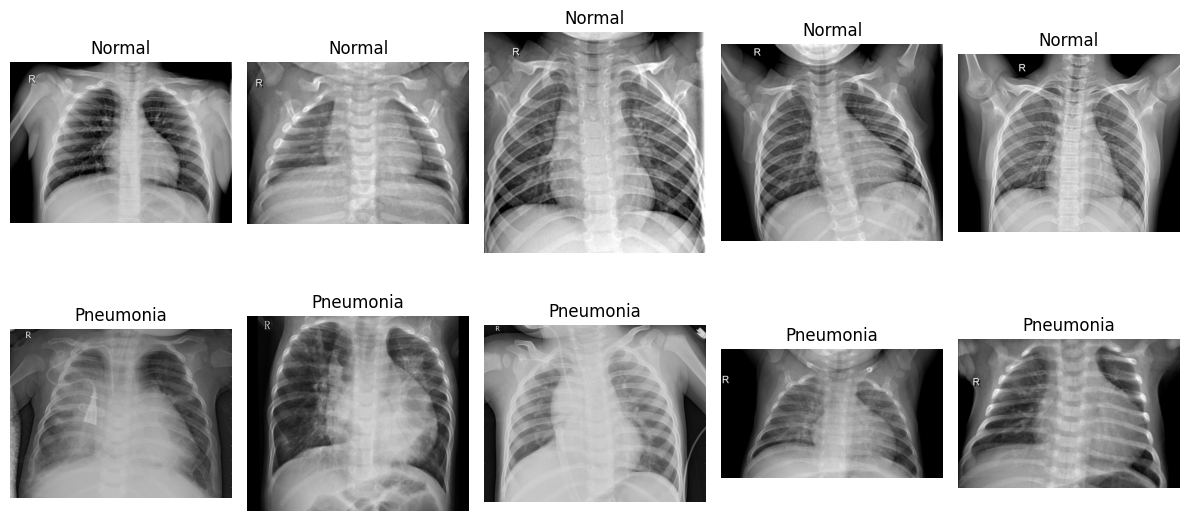

In [ ]:
# plot 5 images from each class from training directory

# Define the paths to the training directories
train_normal_dir = '/content/chest_xray/train/NORMAL'
train_pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'

# Get the list of image files in each directory
normal_images = os.listdir(train_normal_dir)
pneumonia_images = os.listdir(train_pneumonia_dir)

# Plot 5 images from each class
plt.figure(figsize=(12, 6))
for i in range(5):
    # Normal image
    plt.subplot(2, 5, i + 1)
    img_path = os.path.join(train_normal_dir, normal_images[i])
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Normal')
    plt.axis('off')

    # Pneumonia image
    plt.subplot(2, 5, i + 6)
    img_path = os.path.join(train_pneumonia_dir, pneumonia_images[i])
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()


Found 5216 files belonging to 2 classes.


<BarContainer object of 2 artists>

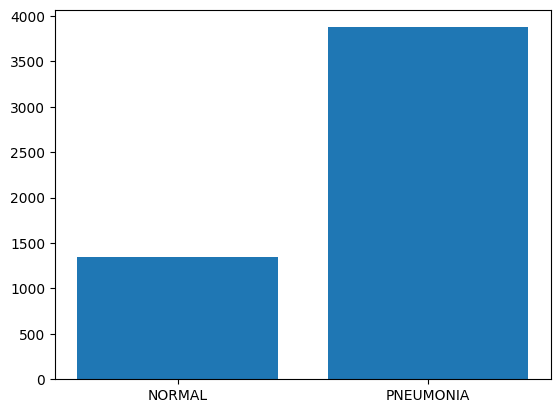

In [ ]:
#Read the data from the directory
train_dataset = image_dataset_from_directory(
    '/content/chest_xray/train',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
# plot the count of labels in training set
class_names = train_dataset.class_names
count = []
for i in range(len(class_names)):
  count.append(len(os.listdir('/content/chest_xray/train/'+class_names[i])))
plt.bar(class_names,count)


## **Resize Data**

In [ ]:
#  resize the images on the train , test and val

# Define the paths to the image directories
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

# Set the desired image size
img_width, img_height = 224, 224

# Function to resize images in a directory
def resize_images(directory):
  for subdir, _, files in os.walk(directory):
    for file in files:
      if file.endswith('.jpeg'):
        filepath = os.path.join(subdir, file)
        img = cv2.imread(filepath)
        resized_img = cv2.resize(img, (img_width, img_height))
        cv2.imwrite(filepath, resized_img)

# Resize images in each directory
resize_images(train_dir)
resize_images(test_dir)
resize_images(val_dir)


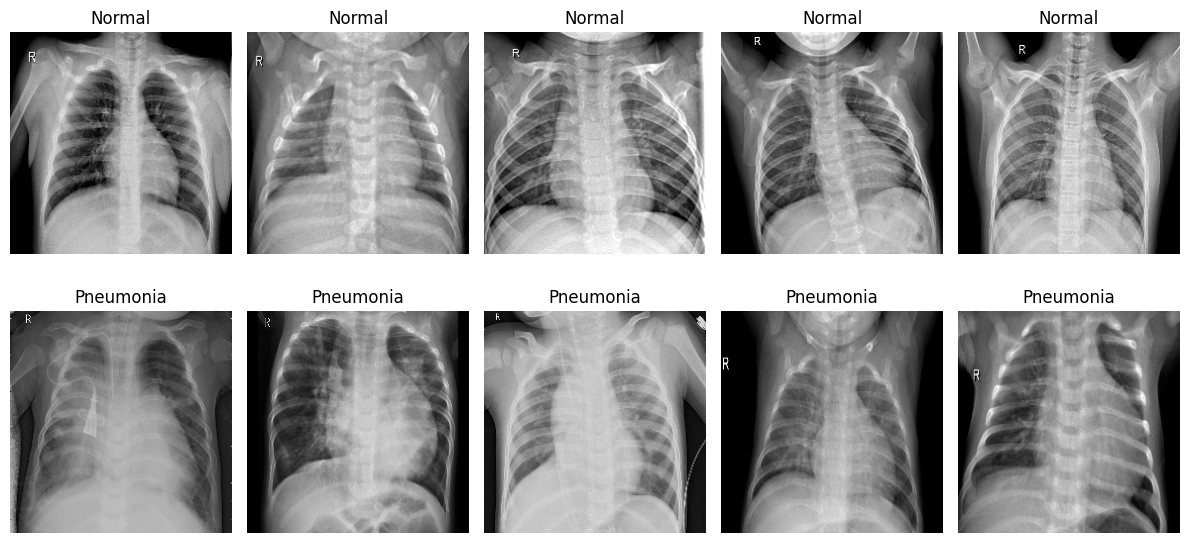

In [ ]:

# Get the list of image files in each directory
normal_images = os.listdir(train_normal_dir)
pneumonia_images = os.listdir(train_pneumonia_dir)

# Plot 5 images from each class
plt.figure(figsize=(12, 6))
for i in range(5):
    # Normal image
    plt.subplot(2, 5, i + 1)
    img_path = os.path.join(train_normal_dir, normal_images[i])
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Normal')
    plt.axis('off')

    # Pneumonia image
    plt.subplot(2, 5, i + 6)
    img_path = os.path.join(train_pneumonia_dir, pneumonia_images[i])
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()


## **Data** **Augmentation**

In [ ]:
# Create ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=.2
)


# Create training generator
train_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',  # Convert images to grayscale
    subset='training'  # Use subset to specify training data
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    '/content/chest_xray/train',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',  # Convert images to grayscale
    subset='validation'  # Use subset to specify validation data
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


In [ ]:
# Test data generator
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    '/content/chest_xray/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

Found 624 images belonging to 2 classes.


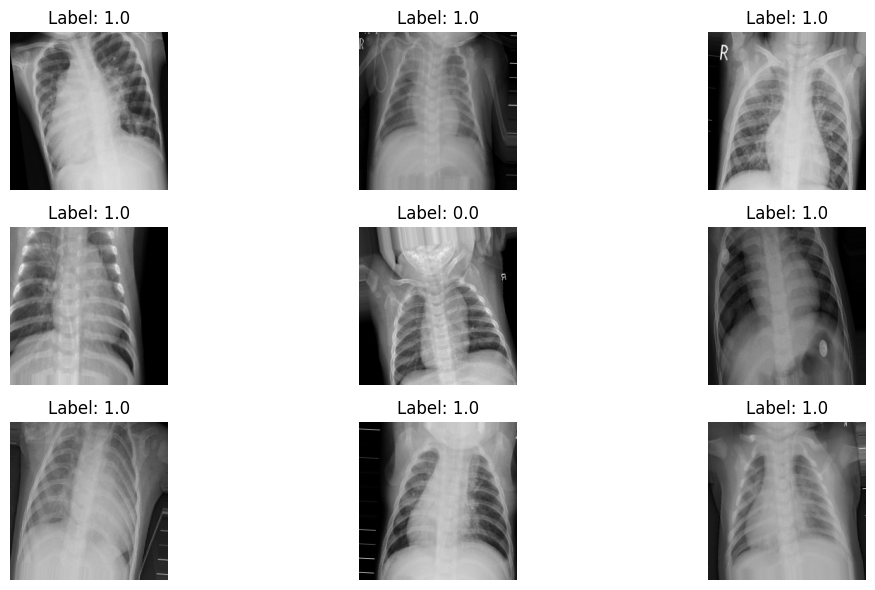

In [ ]:
# show images after generate
import matplotlib.pyplot as plt
# Displaying images from the training generator
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Model Development**

In [ ]:

def plot_confusion_matrix(model, test_generator, class_names):
    """
    Plot the confusion matrix for a given model and test data.

    Parameters:
    model (keras.Model): The trained model
    test_generator (keras.utils.Sequence): The test data generator
    class_names (list): List of class names

    Returns:
    None (displays the plot)
    """
    # Get the true labels for the test set
    y_true = test_generator.classes

    # Predict the labels for the test set
    y_pred_probs = model.predict(test_generator)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Display the values in the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_confusion_matrix(model, test_generator, class_names)


# Define EarlyStopping
EarlyStopping = tf.keras.callbacks.EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)



def plot_accuracy_loss(history):
    """
    Plot the training and validation accuracy and loss curves.

    Parameters:
    history (keras.callbacks.History): The history object returned by model.fit()

    Returns:
    None (displays the plots)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()





In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

### **VGG16**

In [ ]:

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top dense layers
base_model01 = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Add new layers on top of the base model
x = base_model01.output
x = MaxPooling2D()(x)  # Add a max pooling layer
x = Flatten()(x)  # Flatten the output to feed it into dense layers
x = Dense(64, activation='relu')(x)  # Add a dense layer with 64 units
x = Dropout(0.2)(x)  # Add dropout for regularization
x = Dense(1, activation='sigmoid')(x)  # Add the final output layer with sigmoid activation for binary classification

# Create the new model
VGG16_model = Model(inputs=base_model01.input, outputs=x)

# Freeze the layers of the base model
for layer in base_model01.layers:
    layer.trainable = False

# Compile the model
VGG16_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

print(VGG16_model.summary())

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,009,729 (57.26 MB)

 Trainable params: 295,041 (1.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
# Train the model
history_of_vgg = VGG16_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[es],
    class_weight=class_weights
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 639ms/step - accuracy: 0.8647 - loss: 0.2971 - val_accuracy: 0.9233 - val_loss: 0.1752
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 494ms/step - accuracy: 0.9147 - loss: 0.1971 - val_accuracy: 0.9530 - val_loss: 0.1149
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.9487 - loss: 0.1402 - val_accuracy: 0.8859 - val_loss: 0.2987
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 502ms/step - accuracy: 0.9414 - loss: 0.1439 - val_accuracy: 0.9540 - val_loss: 0.1179
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 488ms/step - accuracy: 0.9576 - loss: 0.1190 - val_accuracy: 0.9185 - val_loss: 0.1978
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 488ms/step - accuracy: 0.9621 - loss: 0.1056 - val_accuracy: 0.9434 - val_loss: 0.1325
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 499ms/step - accuracy: 0.9643 - loss: 0.0986 - val_accuracy: 0.9521 - val_loss: 0.1169
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 487ms/step - accuracy: 0.9562 - loss: 0.1259 - va

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = VGG16_model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 493ms/step - accuracy: 0.8992 - loss: 0.2921
Test Loss: 0.2650568187236786
Test Accuracy: 0.9118589758872986


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step


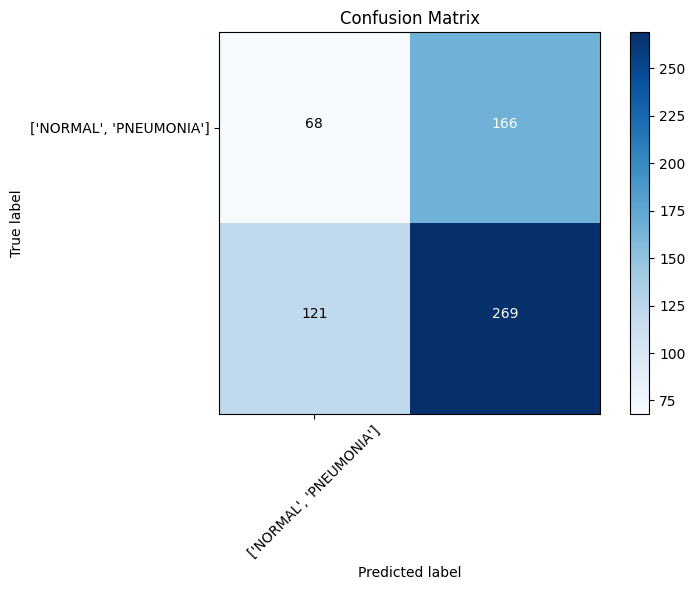

In [ ]:
plot_confusion_matrix(VGG16_model, test_generator, [class_names])

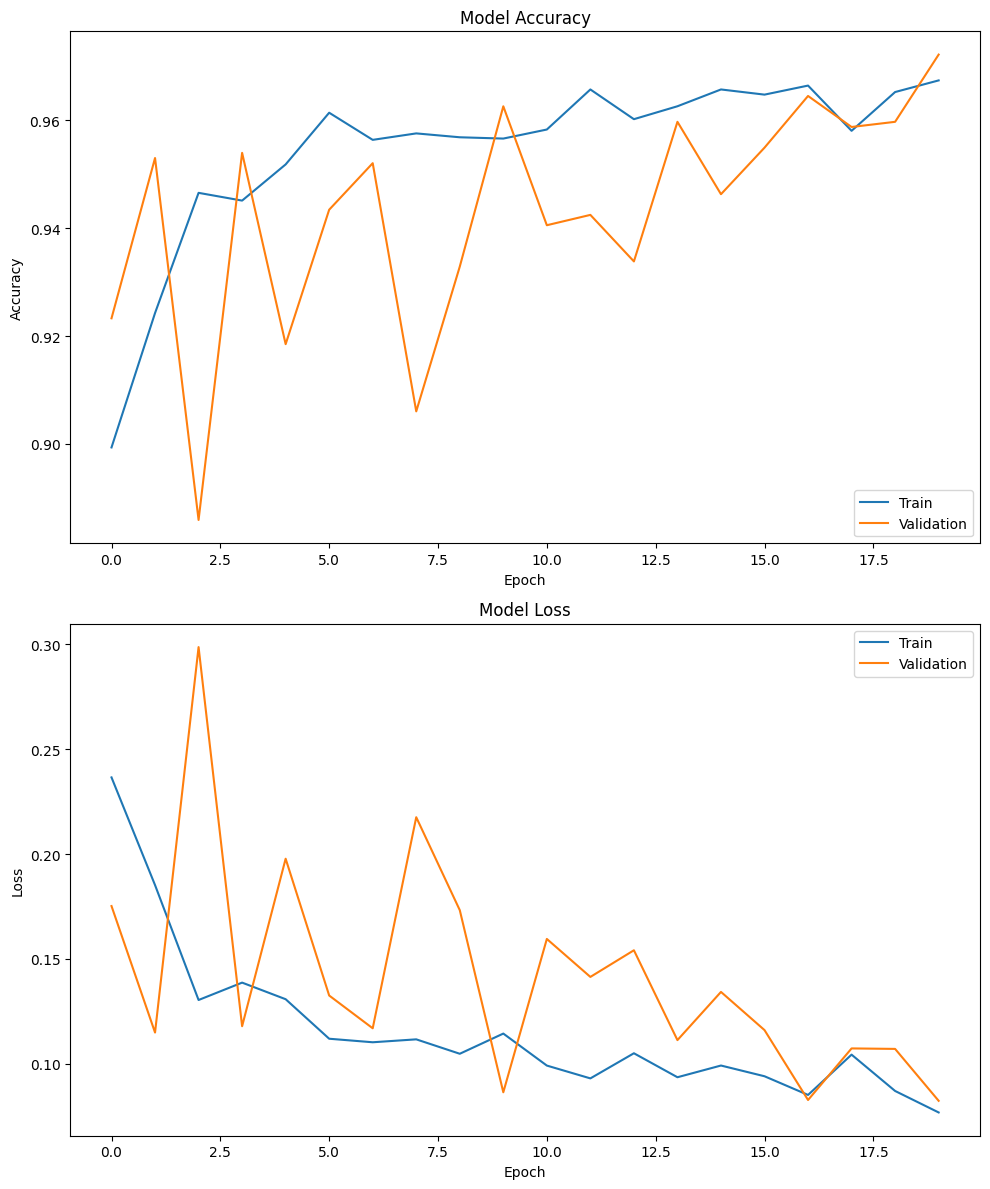

In [ ]:
plot_accuracy_loss(history_of_vgg)

### **VGG16 with unfrozen layers**

In [ ]:

# Unfreeze the last 5 layers of the base model
for layer in base_model01.layers[-5:]:
  layer.trainable = True

# Recompile the model after unfreezing layers
VGG16_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

print(VGG16_model.summary())


history_of_unfrzvgg = VGG16_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[es],
    #class_weight=class_weights
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,009,729 (57.26 MB)

 Trainable params: 7,374,465 (28.13 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 531ms/step - accuracy: 0.7233 - loss: 0.6547 - val_accuracy: 0.7430 - val_loss: 0.5778
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 497ms/step - accuracy: 0.7477 - loss: 0.5706 - val_accuracy: 0.7430 - val_loss: 0.5700
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 512ms/step - accuracy: 0.7453 - loss: 0.5680 - val_accuracy: 0.7430 - val_loss: 0.5699
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 80s 502ms/step - accuracy: 0.7317 - loss: 0.5828 - val_accuracy: 0.7430 - val_loss: 0.5700
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.7411 - loss: 0.5735 - val_accuracy: 0.7430 - val_loss: 0.5698
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 497ms/step - accuracy: 0.7409 - loss: 0.5736 - val_accuracy: 0.7430 - val_loss: 0.5699
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 500ms/step - accuracy: 0.7447 - loss: 0.5695 - val_accuracy: 0.7430 - val_loss: 0.5699
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 500ms/step - accuracy: 0.7386 - lo

In [ ]:
VGG16_model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6209 - loss: 0.6999


[0.6955928802490234, 0.625]

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step


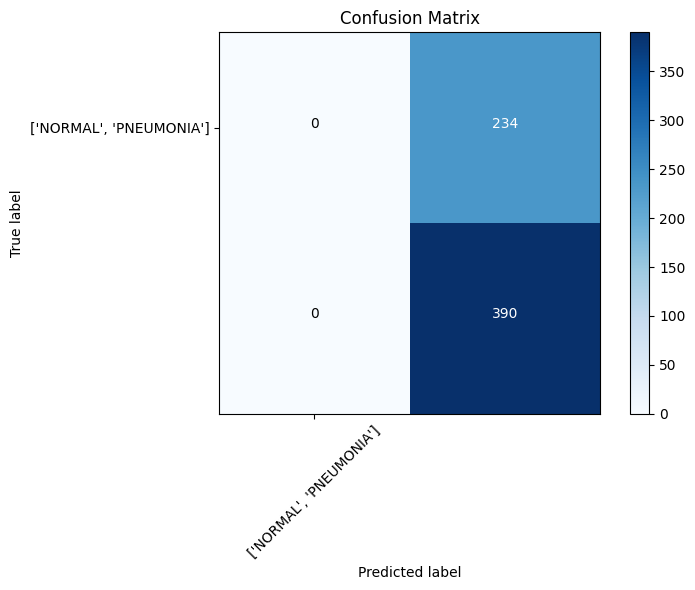

In [ ]:
plot_confusion_matrix(VGG16_model, test_generator, [class_names])

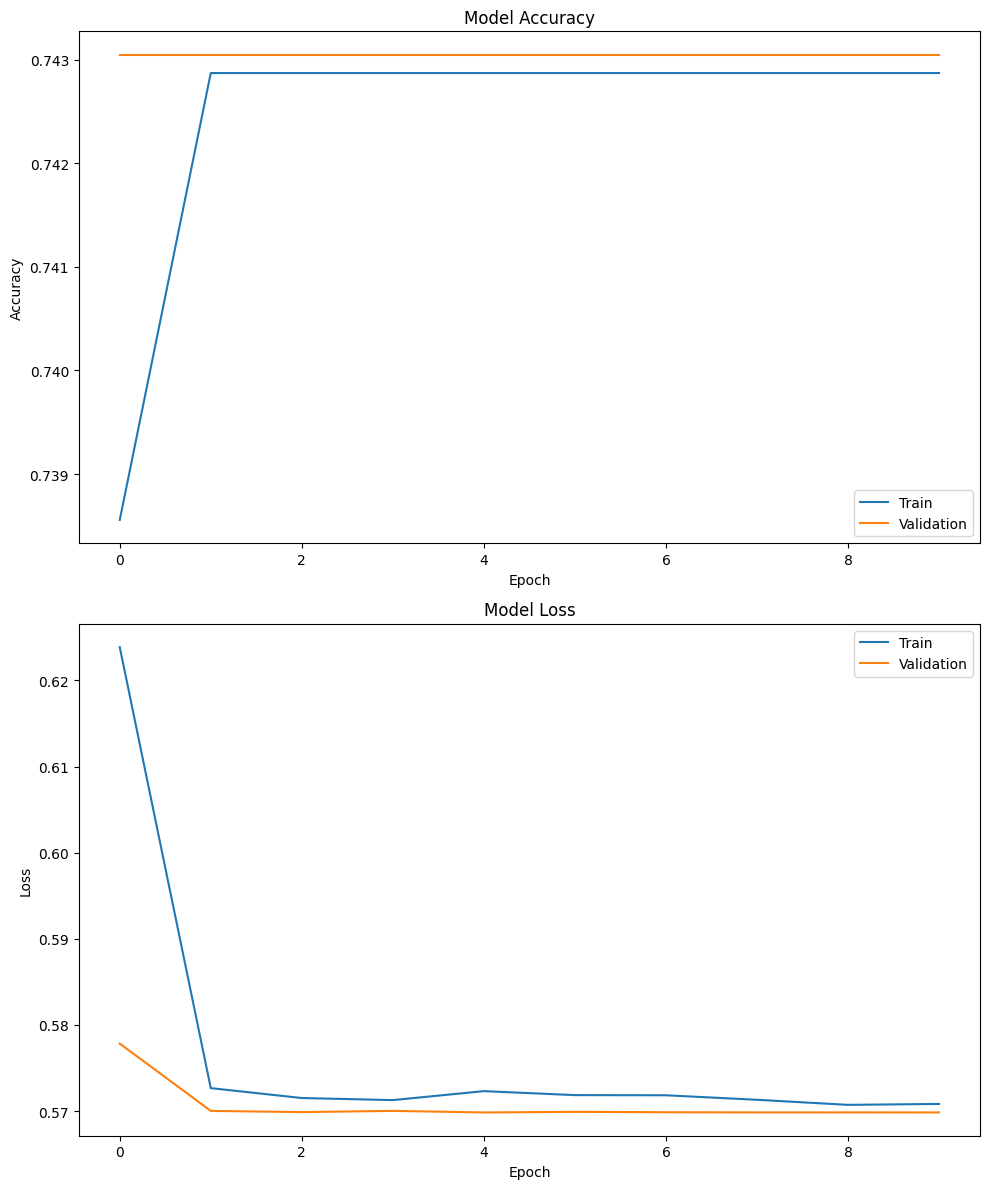

In [ ]:
plot_accuracy_loss(history_of_unfrzvgg)

### **Xception**

In [ ]:

base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

Xception_model = Model(inputs=base_model.input, outputs=predictions)

for layer in Xception_model.layers:
    layer.trainable = False

Xception_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(Xception_model.summary())



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,992,681 (80.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,992,681 (80.08 MB)

None


In [ ]:
history_of_xception = Xception_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[es],
    class_weight=class_weights
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 631ms/step - accuracy: 0.5624 - loss: 0.8206 - val_accuracy: 0.6098 - val_loss: 0.6973
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 502ms/step - accuracy: 0.5630 - loss: 0.8226 - val_accuracy: 0.6012 - val_loss: 0.6949
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 484ms/step - accuracy: 0.5704 - loss: 0.8014 - val_accuracy: 0.6031 - val_loss: 0.6982
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 485ms/step - accuracy: 0.5525 - loss: 0.8132 - val_accuracy: 0.5954 - val_loss: 0.6994
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 486ms/step - accuracy: 0.5822 - loss: 0.8075 - val_accuracy: 0.6040 - val_loss: 0.7040
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 479ms/step - accuracy: 0.5619 - loss: 0.7970 - val_accuracy: 0.5992 - val_loss: 0.6971
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 496ms/step - accuracy: 0.5662 - loss: 0.8003 - val_accuracy: 0.6136 - val_loss: 0.6911
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.5678 - loss: 0.8026 - v

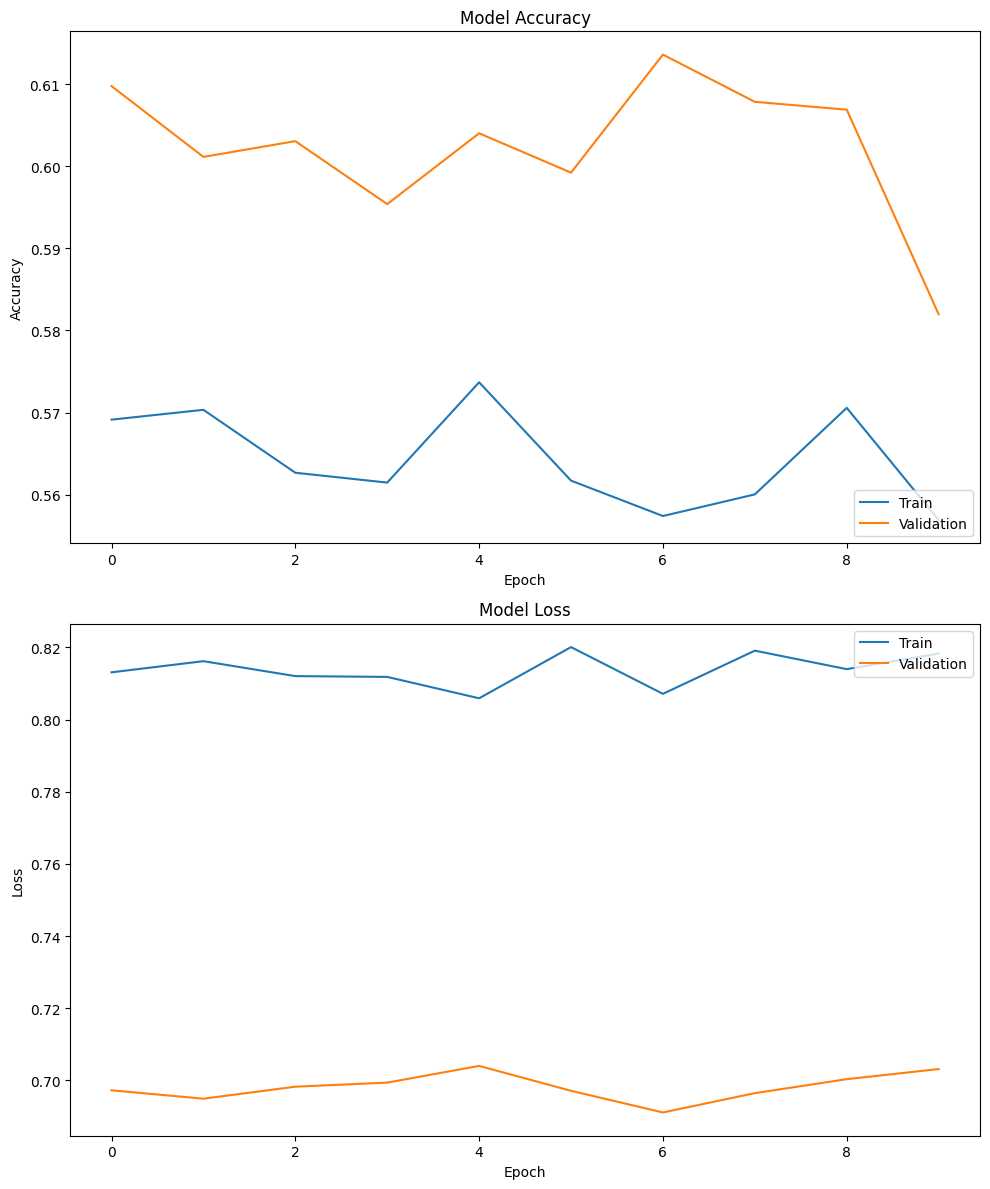

In [ ]:
plot_accuracy_loss(history_of_xception)

In [ ]:
Xception_model.evaluate(test_generator)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.5965 - loss: 0.6801


[0.6822664737701416, 0.5897436141967773]

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step


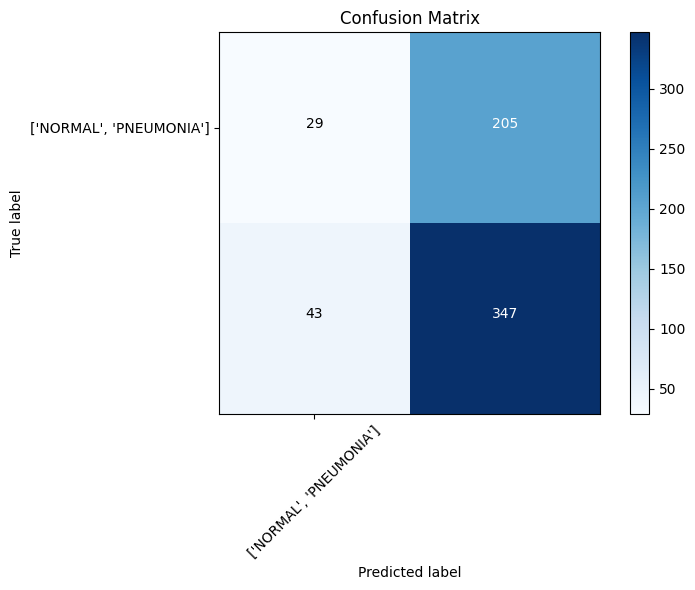

In [ ]:
plot_confusion_matrix(Xception_model, test_generator, [class_names])

### **Xception with unfrozen layers**

In [ ]:
for layer in base_model.layers[-5:]:
  layer.trainable = True

Xception_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
history_of_unfrzXception = Xception_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[es]
)

Epoch 1/50
131/131 [==============================] - 58s 424ms/step - loss: 0.5966 - accuracy: 0.7148 - val_loss: 0.5652 - val_accuracy: 0.7440
Epoch 2/50
131/131 [==============================] - 54s 413ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5690 - val_accuracy: 0.7430
Epoch 3/50
131/131 [==============================] - 54s 415ms/step - loss: 0.5927 - accuracy: 0.7170 - val_loss: 0.5701 - val_accuracy: 0.7411
Epoch 4/50
131/131 [==============================] - 55s 416ms/step - loss: 0.5941 - accuracy: 0.7206 - val_loss: 0.5736 - val_accuracy: 0.7421
Epoch 5/50
131/131 [==============================] - 54s 413ms/step - loss: 0.5979 - accuracy: 0.7175 - val_loss: 0.5718 - val_accuracy: 0.7402
Epoch 6/50
131/131 [==============================] - 54s 415ms/step - loss: 0.5905 - accuracy: 0.7244 - val_loss: 0.5713 - val_accuracy: 0.7430
Epoch 7/50
131/131 [==============================] - 54s 412ms/step - loss: 0.5960 - accuracy: 0.7199 - val_loss: 0.5691 - val_ac

In [ ]:
Xception_model.evaluate(test_generator)

20/20 [==============================] - 1s 65ms/step - loss: 0.6189 - accuracy: 0.6282


[0.6188681125640869, 0.6282051205635071]

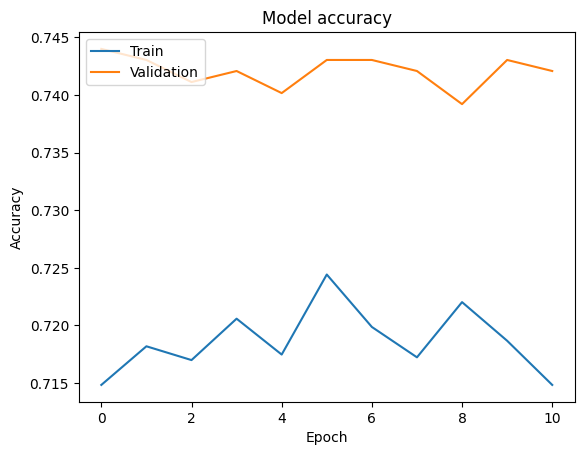

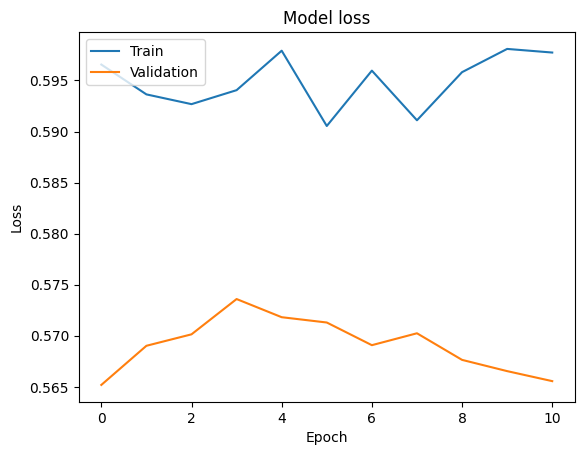

In [ ]:
plot_accuracy_loss(history_of_unfrzXception)

### **Custom Models**

- Model 1

In [ ]:

def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),

        layers.Flatten(),

        layers.Dense(64, activation='relu'),

        layers.Dropout(0.5),

        layers.Dense(32, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
model = create_cnn()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │      11,075,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,134,081 (42.47 MB)

 Trainable params: 11,134,081 (42.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[es]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 419ms/step - accuracy: 0.7191 - loss: 0.7909 - val_accuracy: 0.7430 - val_loss: 0.4313
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.7804 - loss: 0.3801 - val_accuracy: 0.8562 - val_loss: 0.3441
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 386ms/step - accuracy: 0.8598 - loss: 0.3526 - val_accuracy: 0.8658 - val_loss: 0.3395
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.8711 - loss: 0.3368 - val_accuracy: 0.8821 - val_loss: 0.3064
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 391ms/step - accuracy: 0.8868 - loss: 0.3008 - val_accuracy: 0.8830 - val_loss: 0.3026
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.8872 - loss: 0.2858 - val_accuracy: 0.8792 - val_loss: 0.2863
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 388ms/step - accuracy: 0.8942 - loss: 0.2767 - val_accuracy: 0.8754 - val_loss: 0.2801
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.8933 - loss: 0.2717 - val

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8408 - loss: 0.3817
Test Loss: 0.38581380248069763
Test Accuracy: 0.8397436141967773


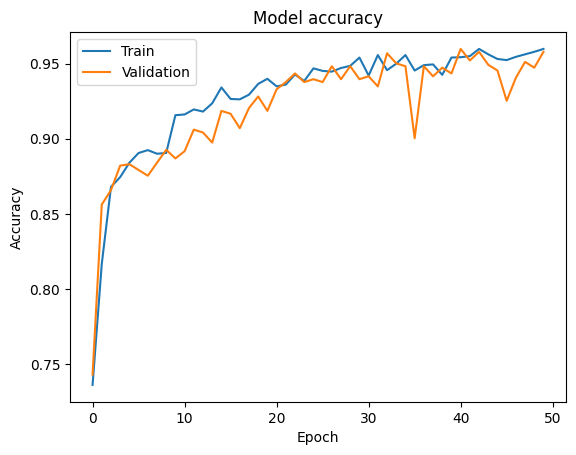

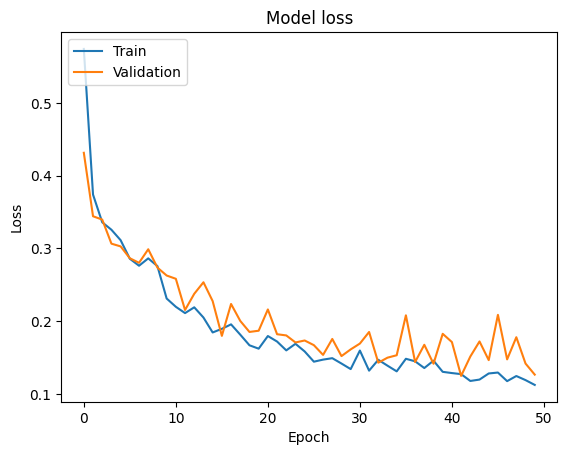

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
plot_accuracy_loss(cnn_history)


- Model 2

In [ ]:

def create_deep_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Flatten(),

        layers.Dense(64, activation='relu'),

        layers.Dropout(0.5),

        layers.Dense(32, activation='relu'),

        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
model = create_deep_cnn()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 54, 54, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │       1,179,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,313,025 (5.01 MB)

 Trainable params: 1,312,513 (5.01 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
cnn_history_01 = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[es]
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 427ms/step - accuracy: 0.7917 - loss: 0.5725 - val_accuracy: 0.7430 - val_loss: 1.5000
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 391ms/step - accuracy: 0.8744 - loss: 0.3486 - val_accuracy: 0.7430 - val_loss: 3.1155
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.8713 - loss: 0.3153 - val_accuracy: 0.7430 - val_loss: 4.3134
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 388ms/step - accuracy: 0.8944 - loss: 0.2658 - val_accuracy: 0.7728 - val_loss: 1.2236
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 388ms/step - accuracy: 0.9074 - loss: 0.2379 - val_accuracy: 0.8859 - val_loss: 0.3339
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.9072 - loss: 0.2307 - val_accuracy: 0.7593 - val_loss: 0.4909
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.9098 - loss: 0.2171 - val_accuracy: 0.8965 - val_loss: 0.2322
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 53s 389ms/step - accuracy: 0.9335 - loss: 0

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.7188 - loss: 2.3248
Test Loss: 2.5031802654266357
Test Accuracy: 0.7083333134651184


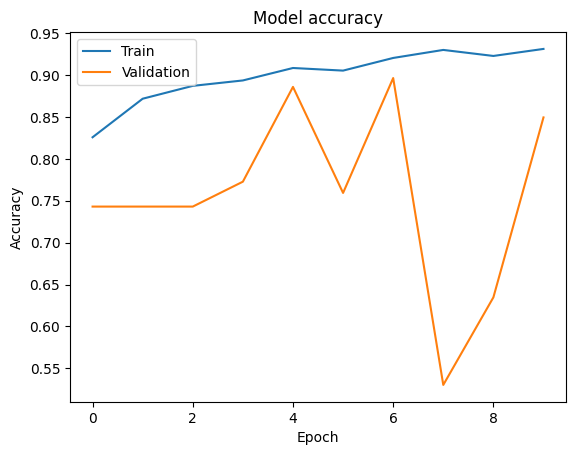

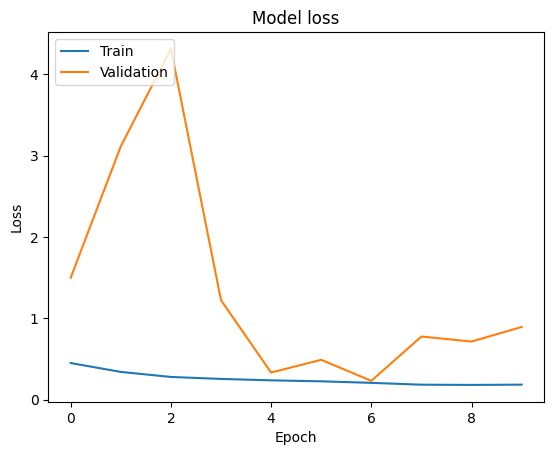

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
plot_accuracy_loss(cnn_history_01)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


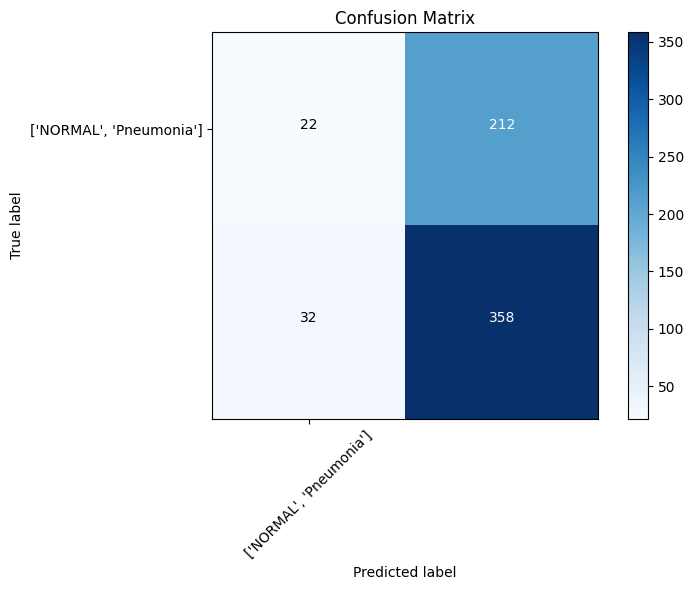

In [ ]:
plot_confusion_matrix(model, test_generator, [class_names])


# **Summary**

- VGG with class weight was the best moel I have got